# <font color="RoyalBlue">Energy Price Prediction - Introduction</font>

This university project focuses on predicting the **German EPEX Spot electricity prices** on an hourly basis using Python and Jupyter Notebooks. The main goal is to build a regression model that can predict these electricity prices based on historical data ranging from January 2015 to the end of December 2024. 

The notebook follows a typical machine learning workflow as well as common best practices. Each individual step is thoroughly documented by markdown cells and comments in code. Relevant technical terms are explained where necessary to ensure a clear understanding of each process. A dedicated Exploratory Data Analysis (EDA) will provide deeper insights into the German electricity market in order to gain a sufficient amount of domain knowledge for later feature selection.

We will train a single `XGBoost` regression model and evaluate it using key metrics. The notebook concludes with a summary of the project and a discussion of several potential improvements.

## Table of Contents:
1) Data Integration
2) Merging the DataFrames
3) Adding Time Based Features
4) Exploratory Data Analysis (EDA)
5) Handling Missing Values
6) Adding Lag Features, Rolling Statistics and Handling Outliers
7) Model Training, Prediction and Evaluation
8) Conclusion

# <font color="RoyalBlue">1 Data Integration</font>
First of all, before loading in our data, we import all the necessary libraries for this project. This includes data analysis tools such as `numpy` and `pandas`, visualization libraries like `matplotlib` and `seaborn`, machine learning frameworks including `XGBoost` and `scikit-learn`, as well as a library for handling German public `Holidays`.

In [757]:
# Data Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Holidays
import holidays

After importing all these libraries, let's integrate our data in the following section. This data will then be used to train our model in the final chapters of this Notebook.

Note that all data used refers exclusively to the **German price zone of the EPEX Spot electricity market** from **january 2015 until december 2024**. For this, we use a total of **three CSV files** in order to retrieve our data. Firstly, each CSV file's content will be saved in its own Pandas DataFrame. Later on, they will all be merged together into just one DataFrame by using their date and hour attribute as a primary key. However, before merging, we take a brief look at each DataFrame and remove unnecessary and redundant information that could damage our model prediction. Moreover, we address certain challenges such as converting data types and handling the German daylight saving time transitions. All of this will be covered throughout this first chapter.

## EPEX Spot Price Data
The first data set contains the hourly EPEX Spot prices and looks as follows:

In [758]:
df_prices = pd.read_csv("../data/germany_epex_spot.csv")

# Print data types and first five rows
print(df_prices.dtypes)
df_prices.head()

Country              object
ISO3 Code            object
Datetime (UTC)       object
Datetime (Local)     object
Price (EUR/MWhe)    float64
dtype: object


,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Germany,DEU,2015-01-01 00:00:00,2015-01-01 01:00:00,22.34
1,Germany,DEU,2015-01-01 01:00:00,2015-01-01 02:00:00,22.34
2,Germany,DEU,2015-01-01 02:00:00,2015-01-01 03:00:00,22.34
3,Germany,DEU,2015-01-01 03:00:00,2015-01-01 04:00:00,22.34
4,Germany,DEU,2015-01-01 04:00:00,2015-01-01 05:00:00,22.34


We can obviously remove the columns `Country`, `ISO3 Code` and `Datetime (UTC)` because they wont be needed for the model training. With regard to merging the individual DataFrames later, we will also rename the column `Datetime (Local)` that represents our primary key to `timestamp`. Furthermore, we need to convert this timestamp's data type into a valid datetime type. Because the decimal numbers in the price column have already been in a valid float number format, we do not need to adjust anything here. In fact, all columns containing number values in each of the three CSV files are already saved in a valid float value format, so we don't have to take care of this in future.

In [759]:
# Rename important Columns to snake case format
df_prices = df_prices.rename(columns={
    "Datetime (Local)": "timestamp",
    "Price (EUR/MWhe)": "price_eur_per_mwh"
})

# Only keep relevant Columns
df_prices = df_prices[["timestamp", "price_eur_per_mwh"]]

# Convert data type from string to datetime64[ns]
df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"])

# Print data types and first five rows again
print(df_prices.dtypes)
df_prices.head()

timestamp            datetime64[ns]
price_eur_per_mwh           float64
dtype: object


,timestamp,price_eur_per_mwh
0,2015-01-01 01:00:00,22.34
1,2015-01-01 02:00:00,22.34
2,2015-01-01 03:00:00,22.34
3,2015-01-01 04:00:00,22.34
4,2015-01-01 05:00:00,22.34


## Energy Consumption Forecast Data

The next data set contains information about the energy consumption and includes hourly forecasts for the demand of net load and residual load. The **net load** represents the total electricity demand at a given time, including all consumers, whereas the **residual load** refers the the remaining electricity demand that must be met by controllable power plants after subtracting generation from renewable sources like wind and solar. The DataFrame as well as its current data types look as follows:

In [760]:
df_consumption = pd.read_csv("../data/energy_consumption_forecast.csv", delimiter=";", na_values="-") # NaN values are saved as a "-"

# Print data types and first five rows
print(df_consumption.dtypes)
df_consumption.head()

Date from                       object
Date to                         object
Forecast Netload[MWh]          float64
Forecast Residual Load[MWh]    float64
dtype: object


,Date from,Date to,Forecast Netload[MWh],Forecast Residual Load[MWh]
0,01.01.2015 00:00,01.01.2015 01:00,49306.25,41399.00
1,01.01.2015 01:00,01.01.2015 02:00,46952.50,38481.50
2,01.01.2015 02:00,01.01.2015 03:00,45751.50,37152.25
3,01.01.2015 03:00,01.01.2015 04:00,45306.25,36638.50
4,01.01.2015 04:00,01.01.2015 05:00,45423.00,36580.50


Just like with the first DataFrame, we can remove unnecessary columns and rename others. Note the `na_values` parameter in the code above, that is used to tell pandas, that the loaded CSV files data uses a single `-` symbol in order to implicate NaN values.

In [761]:
# Rename important columns to snake case format
df_consumption = df_consumption.rename(columns={
    "Date from": "timestamp",
    "Forecast Netload[MWh]": "forecast_net_load_mwh",
    "Forecast Residual Load[MWh]": "forecast_residual_load_mwh"
})

# Get rid of unnecessary "Date to" column
df_consumption.drop(columns=["Date to"], inplace=True)

# Convert data type from string to datetime64[ns]
df_consumption["timestamp"] = pd.to_datetime(df_consumption["timestamp"], format="%d.%m.%Y %H:%M")

# Print data types and first five rows again
print(df_consumption.dtypes)
df_consumption.head()

timestamp                     datetime64[ns]
forecast_net_load_mwh                float64
forecast_residual_load_mwh           float64
dtype: object


,timestamp,forecast_net_load_mwh,forecast_residual_load_mwh
0,2015-01-01 00:00:00,49306.25,41399.00
1,2015-01-01 01:00:00,46952.50,38481.50
2,2015-01-01 02:00:00,45751.50,37152.25
3,2015-01-01 03:00:00,45306.25,36638.50
4,2015-01-01 04:00:00,45423.00,36580.50


## Power Generation Forecast Data
Finally, we will also include data containing hourly forecasts for energy generation. These include **forecasts on solar and wind energy generation** as well as **Other Sources**, meaning all remaining energy sources that have not been explicitly stated in other columns, such as biomass, hydropower, nuclear, coal and gas. Again, we print the first five rows of our data as well as its data types:

In [762]:
df_generation = pd.read_csv("../data/power_generation_forecast.csv", delimiter=";", na_values="-")

# Print data types and first five rows
print(df_generation.dtypes)
df_generation.head()

Date from                         object
Date until                        object
Forecast Total [MWh]             float64
Forecast Wind and Solar [MWh]    float64
Forecast Wind Offshore [MWh]     float64
Forecast Wind Onshore [MWh]      float64
Forecast Solar [MWh]             float64
Forecast Other Sources [MWh]     float64
dtype: object


,Date from,Date until,Forecast Total [MWh],Forecast Wind and Solar [MWh],Forecast Wind Offshore [MWh],Forecast Wind Onshore [MWh],Forecast Solar [MWh],Forecast Other Sources [MWh]
0,01.01.2015 00:00,01.01.2015 01:00,58974.0,7907.25,258.50,7648.75,0.0,51066.75
1,01.01.2015 01:00,01.01.2015 02:00,57681.0,8471.00,258.75,8212.25,0.0,49210.00
2,01.01.2015 02:00,01.01.2015 03:00,56256.0,8599.25,258.50,8340.75,0.0,47656.75
3,01.01.2015 03:00,01.01.2015 04:00,54432.0,8667.75,259.00,8408.75,0.0,45764.25
4,01.01.2015 04:00,01.01.2015 05:00,54522.0,8842.50,260.50,8582.00,0.0,45679.50


Just like before, there is some work to do, such as removing and renaming some columns as well as converting the timestamps data type:

In [763]:
# Remove unnecessary columns
df_generation = df_generation.drop(columns=[
    "Date until",
    "Forecast Wind and Solar [MWh]"
])

# Rename important columns to snake case format
df_generation = df_generation.rename(columns={
    "Date from": "timestamp",
    "Forecast Total [MWh]": "forecast_total_mwh",
    "Forecast Wind Offshore [MWh]": "forecast_wind_offshore_mwh",
    "Forecast Wind Onshore [MWh]": "forecast_wind_onshore_mwh",
    "Forecast Solar [MWh]": "forecast_solar_mwh",
    "Forecast Other Sources [MWh]": "forecast_other_mwh"
})

# Convert timestamp to datetime type
df_generation["timestamp"] = pd.to_datetime(df_generation["timestamp"], format="%d.%m.%Y %H:%M")

# Print data types and first five rows again
print(df_generation.dtypes)
df_generation.head()

timestamp                     datetime64[ns]
forecast_total_mwh                   float64
forecast_wind_offshore_mwh           float64
forecast_wind_onshore_mwh            float64
forecast_solar_mwh                   float64
forecast_other_mwh                   float64
dtype: object


,timestamp,forecast_total_mwh,forecast_wind_offshore_mwh,forecast_wind_onshore_mwh,forecast_solar_mwh,forecast_other_mwh
0,2015-01-01 00:00:00,58974.0,258.50,7648.75,0.0,51066.75
1,2015-01-01 01:00:00,57681.0,258.75,8212.25,0.0,49210.00
2,2015-01-01 02:00:00,56256.0,258.50,8340.75,0.0,47656.75
3,2015-01-01 03:00:00,54432.0,259.00,8408.75,0.0,45764.25
4,2015-01-01 04:00:00,54522.0,260.50,8582.00,0.0,45679.50


We have now successfully loaded in our data and obtained three DataFrames, each containing a `timestamp` column. In order to merge these three DataFrames together, we want to ensure that the `timestamp` column is suitable for merging. This will be covered in the next chapter.

# <font color="RoyalBlue">2 Merging the DataFrames</font>

In this section, we will merge all of our DataFrames together into a single DataFrame that will later be used for the model training. Before actually merging, we take a close look at the `timestamp` column of each DataFrame. As part of this, we will be confronted with a small problem: the **German Daylight Saving Time Change**. After handling this problem, we quickly validate that our merge was successful.

## Making sure that we are ready to merge
After loading in the data, creating our DataFrames and converting some data types, we are now theoretically ready to merge them together into just one single DataFrame. However, before that, let's make sure that each DataFrame's `timestamp` column is valid to be merged on. We will see that this is not the case right now! The following code block shows some considerations regarding whether we are ready to merge or not by making sure that:
- all DataFrames have a common `timestamp` column
- which is saved as a valid `datetime64` type
- and is never `NaN`
- and has no duplicates

In [764]:
# Make sure that we have a common timestamp column
common_columns = set(df_generation.columns).intersection(df_consumption.columns).intersection(df_prices.columns)
print(f"Common columns between all DataFrames: {common_columns}\n")

# Let's also make sure that the data type of each timestamp is correct
print(f"Data type df_prices['timestamp']: {df_prices["timestamp"].dtype}")
print(f"Data type df_generation['timestamp']: {df_generation["timestamp"].dtype}")
print(f"Data type df_consumption['timestamp']: {df_consumption["timestamp"].dtype}\n")

# Check if timestamp is NaN anywhere
print(f"df_prices has {df_prices["timestamp"].isna().sum()} timestamp values that are NaN")
print(f"df_generation has {df_generation["timestamp"].isna().sum()} timestamp values that are NaN")
print(f"df_consumption has {df_consumption["timestamp"].isna().sum()} timestamp values that are NaN\n")

# Print the amount of common timestamp values
common_values = set(df_generation["timestamp"]).intersection(df_consumption["timestamp"]).intersection(df_prices["timestamp"])
print(f"Common values between all DataFrames: {len(common_values)}\n")

# Check for any timestamp duplicates -> Daylight Saving Time Change!?
print(df_prices[df_prices.duplicated(subset="timestamp")])
print(df_generation[df_generation.duplicated(subset="timestamp")])
print(df_consumption[df_consumption.duplicated(subset="timestamp")])


Common columns between all DataFrames: {'timestamp'}

Data type df_prices['timestamp']: datetime64[ns]
Data type df_generation['timestamp']: datetime64[ns]
Data type df_consumption['timestamp']: datetime64[ns]

df_prices has 0 timestamp values that are NaN
df_generation has 0 timestamp values that are NaN
df_consumption has 0 timestamp values that are NaN

Common values between all DataFrames: 87661

                timestamp  price_eur_per_mwh
7129  2015-10-25 02:00:00              25.02
16033 2016-10-30 02:00:00              31.55
24769 2017-10-29 02:00:00             -83.00
33505 2018-10-28 02:00:00              44.06
42241 2019-10-27 02:00:00             -10.38
50977 2020-10-25 02:00:00              -6.39
59881 2021-10-31 02:00:00              58.26
68617 2022-10-30 02:00:00              95.29
77353 2023-10-29 02:00:00               7.58
86089 2024-10-27 02:00:00              68.62
                timestamp  forecast_total_mwh  forecast_wind_offshore_mwh  \
7130  2015-10-25 02:00:0

## Duplicate Timestamps (Daylight Saving Time)

As seen above, the datasets contain exactly one duplicate timestamp at Hour 02:00 on the last Sunday of October every year. This occurs due to the end of Daylight Saving Time in Germany, when clocks are set back one hour. As a result, the hour between 02:00 and 03:00 appears twice. Clocks are set forward again on the last Sunday of March. These duplicate timestamps need to be handled accordingly, for example by using timezone-aware timestamps, removing duplicates, or differentiating them manually. For this project, it is sufficient to just remove these duplicates.

In [765]:
# Remove duplicates that result from daylight saving time
df_prices = df_prices[~df_prices.duplicated(subset="timestamp")]
df_generation = df_generation[~df_generation.duplicated(subset="timestamp")]
df_consumption = df_consumption[~df_consumption.duplicated(subset="timestamp")]

# Check if there are duplicates left
print(f"Amount of duplicates in df_prices: {df_prices["timestamp"].duplicated().sum()}")
print(f"Amount of duplicates in df_generation: {df_generation["timestamp"].duplicated().sum()}")
print(f"Amount of duplicates in df_consumption: {df_consumption['timestamp'].duplicated().sum()}")

Amount of duplicates in df_prices: 0
Amount of duplicates in df_generation: 0
Amount of duplicates in df_consumption: 0


## Merging the DataFrames
We are now ready to merge all three DataFrames into one and set the index to `timestamp`. Besides our timestamp-index, the merged DataFrame only contains float values for now. This will change in the next chapter when we add some more features. After merging, it is best to quickly verify if the merge was valid. This is because even if the merge itself runs without errors, issues such as misaligned timestamps, unexpected duplicates or missing data can lead to incorrect results or inconsistencies in the dataset.

In [766]:
# Now merge the DataFrames ...
df = pd.merge(
    df_prices,
    df_consumption,
    on="timestamp",
    how="inner"
)

df = pd.merge(
    df,
    df_generation,
    on="timestamp",
    how="inner"
)

# We should have 0 duplicate timestamps
duplicates = df["timestamp"].duplicated().sum()
print(f"Duplicate timestamps: {duplicates}\n")

# Set timestamp as index
df = df.set_index("timestamp")
df = df.sort_index()

# Check if merge is valid
common_timestamps = set(df_prices["timestamp"]) & set(df_consumption["timestamp"]) & set(df_generation["timestamp"])
print(f"Expected number of rows: {len(common_timestamps)}")
print(f"Actual number of rows: {len(df)}\n")

# Print general info of merged DataFrame
df.info()

Duplicate timestamps: 0

Expected number of rows: 87661
Actual number of rows: 87661

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87661 entries, 2015-01-01 01:00:00 to 2024-12-31 23:00:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price_eur_per_mwh           87661 non-null  float64
 1   forecast_net_load_mwh       86362 non-null  float64
 2   forecast_residual_load_mwh  86338 non-null  float64
 3   forecast_total_mwh          87589 non-null  float64
 4   forecast_wind_offshore_mwh  87637 non-null  float64
 5   forecast_wind_onshore_mwh   87659 non-null  float64
 6   forecast_solar_mwh          87659 non-null  float64
 7   forecast_other_mwh          87565 non-null  float64
dtypes: float64(8)
memory usage: 6.0 MB


It is important to note, that we can still have NaN values in our data! By now, we only know that our timestamp column, that is now being used as the DataFrames index, had no NaN values. Let's print the numbers of NaN values in each column:

In [767]:
# Absolute and percentage amount of NaN values
missing_count = df.isna().sum()
missing_percent = (missing_count / len(df)) * 100

# Print the results
missing_info = pd.DataFrame({
    "Missing Values": missing_count,
    "Percentage (%)": missing_percent.round(2)
})
print(f"Missing values per column (absolute and in %):\n {missing_info}")

Missing values per column (absolute and in %):
                             Missing Values  Percentage (%)
price_eur_per_mwh                        0            0.00
forecast_net_load_mwh                 1299            1.48
forecast_residual_load_mwh            1323            1.51
forecast_total_mwh                      72            0.08
forecast_wind_offshore_mwh              24            0.03
forecast_wind_onshore_mwh                2            0.00
forecast_solar_mwh                       2            0.00
forecast_other_mwh                      96            0.11


We can ignore these for now and come back to this problem in a later chapter. At this point, we have successfully obtained a single, clean, and valid DataFrame. This sets the foundation for the next chapter, where we will add additional features to enhance the quality of future model predictions.

# <font color="RoyalBlue">3 Adding Time Based Features</font>

Creating and adding new features is a crucial part of machine learning, as these features provide the model with additional information to improve its predictions. This process is referred to as **Feature Engineering**. In this chapter, we will add the following features based on our timestamp data:
- Hour, weekday, month and year
- German public Holidays
- Binary indicator for the DE-AT to DE-LU price zone split in October 2018

It is safe to derive features from our timestamp index, as we have verified that it is valid and contains no missing values. We begin by extracting hour, weekday, month and year:

In [768]:
# Derive time based information from our timestamp index
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df["month"] = df.index.month
df["year"] = df.index.year

Secondly, we enrich our dataset with information about the **German public holidays** by using the `Holidays` library. Note that we use One-Hot-Encoding for each holiday. This is necessary, because some models cannot work with String types such as `New Year`. Furthermore, we should avoid using sequentially incrementing numbers (e.g. 0 = no holiday, 1 = New Year, 2 = Easter Monday, ...) for encoding the holidays, as this can imply ordinal relationships of the holidays and thus lead to misinterpretation by the model and negatively affect prediction accuracy! Additionally, holidays that do not fall on a fixed date, such as Easter, are automatically handled by the `Holidays` library.

In [769]:
# Get German holidays for all years in the data (2015-2025)
years = df.index.year.unique() 
de_holidays = holidays.Germany(years=years)

# Map holidays to the DataFrame
df["holiday_name"] = df.index.normalize().map(de_holidays)

# Print all holidays
unique_holidays = df["holiday_name"].dropna().unique()
print(unique_holidays)

# One-hot encode holiday names
holiday_onehot = pd.get_dummies(df["holiday_name"], prefix="holiday")

# Append one-hot columns and drop original holiday column
df = pd.concat([df, holiday_onehot], axis=1)
del df["holiday_name"] # string types not suitable for training!

['Neujahr' 'Karfreitag' 'Ostermontag' 'Erster Mai' 'Christi Himmelfahrt'
 'Pfingstmontag' 'Tag der Deutschen Einheit' 'Erster Weihnachtstag'
 'Zweiter Weihnachtstag' 'Reformationstag']


Finally, we need to address the **split of the EPEX Spot price zone of Germany on October 1st 2018**, which marked a **structural change** in the German electricity market. Before this date, Germany and Austria shared a common bidding zone (DE-AT). After the split, the price zone for Germany includes only Luxembourg (DE-LU). We represent this change by adding a binary feature indicating whether the timestamp is before or after the price zone split.

In [770]:
df["pricezone_split"] = (df.index >= pd.to_datetime("2018-10-01")).astype(int) # we use int because some models require numeric inputs

We have now successfully added some new features to our DataFrame. In the course of the next chapters, we will add even more features to further improve our model.

# <font color="RoyalBlue">4 Exploratory Data Analysis (EDA)</font>
It is crucial to have a thorough understanding of the data you are working with. Therefore, in this chapter, we will explore and visualize the data to better identify patterns and correlations. Note that this analysis is done before handling NaN values. The information gained in this chapter can be used in the following chapters, when we finally **prepare**, **split** and **utilize** our data for model training. For example, we will add a new feature that provides information about the frequency of negative electricity prices values. 

## German EPEX Spot Electricity Prices

We start our EDA by plotting some of the numerical features of our DataFrame. For this purpose, we define a simple function `plot_feature` which plots a specified feature from the DataFrame `df`. Additionally, by passing a boolean parameter `rolling_window`, it is possible to display the moving average to further highlight the trend of the plotted feature over time. The start and end dates of the plotted data can also be specified as parameters. Through the `event` parameter, a list of events can be passed and displayed on the plot. Each event consists of a start date and name.

In [771]:
def plot_feature(
        df,
        feature_name,
        label_name,
        ylabel="Wert",
        rolling_window=False,
        line_color="blue",
        average_color="orange",
        start_date="2015-01-01",
        end_date="2024-12-31",
        events=None
):
    """
    Plots a feature from start_date until end_date as well as a moving average. 
    Additionally, events can be passed as a tuple to provide further information about geopolitical context. 
    
    Parameters:
    - df: a DataFrame with datetime index
    - feature_name: name of the column to plot as a string
    - label_name: name of the label to show in th eplot
    - ylabel: y-axis description as a string
    - rolling_window: whether to show the floating average
    - line_color: the color of the plotted feature
    - average_color: the color of the drawn moving average
    - start_date: the start of the date range to plot
    - end_date: the end of the date range to plot
    - events: a list of events to be displayed on the plot, consisting of a name and start date
    """
    plt.figure(figsize=(14, 3))

    # Define date limits
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    # Plot the feature
    plt.plot(df.index, df[feature_name], label=label_name, linewidth=0.3, alpha=0.7, color=line_color)
    
    # Plot a Floating Average (optional)
    if rolling_window:
        rolling = df[feature_name].rolling(window=500, min_periods=1).mean()
        plt.plot(df.index, rolling, label=f"Moving Average", linewidth=1.0, color=average_color)
    
    # Highlight Events
    if events:
        for event_date, event_label in events:
            event_date = pd.Timestamp(event_date)
            if start_date <= event_date <= end_date:
                plt.axvline(x=event_date, color="purple", linestyle="--", linewidth=1)
                plt.text(event_date, plt.ylim()[1]*0.95, event_label, rotation=90, color="red", verticalalignment="top", horizontalalignment="right", fontsize=8)
    
    # Limit the x-axis to the date range
    plt.xlim(start_date, end_date)

    # Finish configuration
    plt.title(feature_name)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout() # adjust plot spacing to prevent overlaps and improve readability
    plt.show()


For this first plot, we want to display the actual **electricity prices of the German EPEX Spot Market** in EUR per MWh from 2015 until 2025. We use our `plot_feature` function and pass a list of important events in order to visualize them on the plot. Those events as well as a moving average will help us to contextualize major shifts in the price trend.

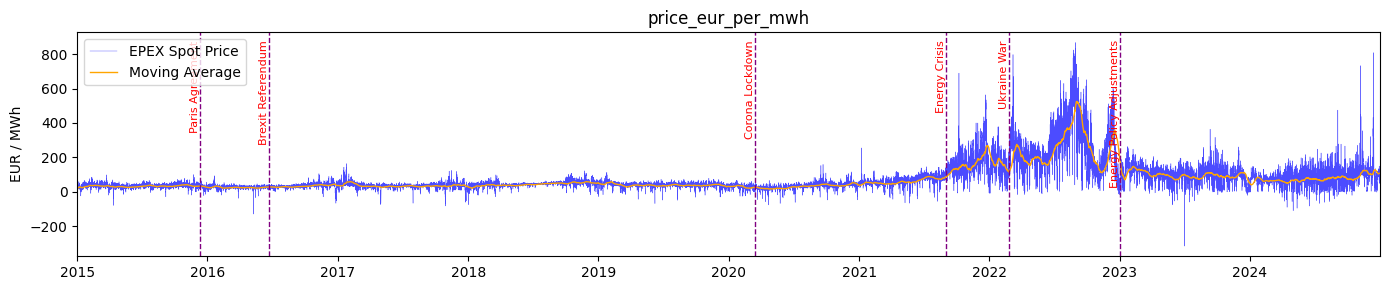

In [772]:
# Geopolitical events influencing the EPEX Spot Market
events = [
    ("2015-12-12", "Paris Agreement"),
    ("2016-06-23", "Brexit Referendum"),
    ("2020-03-15", "Corona Lockdown"),
    ("2021-09-01", "Energy Crisis"),
    ("2022-02-24", "Ukraine War"),
    ("2023-01-01", "Energy Policy Adjustments"),
]

plot_feature(df, "price_eur_per_mwh", "EPEX Spot Price", ylabel="EUR / MWh", rolling_window=200, events=events)

<u>Notable Observations from the Plot:</u>
- There is a long-term sustaining price from 2015 until 2021, due to **lack of major disruptive events**.
- The **Corona lockdown** in 2020 initially caused a demand drop that led to lower energy prices, but supply chain disruptions later caused volatility.
- Slight upward trend starting at 2021, likely due to the corona virus and **lockdown measures** as well as high gas prices.
- Sharp price spikes after the **energy crisis** in late 2021, but especially after the start of the **Ukraine War** on febuary 2022 which caused significant gas shortages.
- Due to **energy policy adjustments** such as government price caps, more renewable energy but also due to a mild winter, prices appear to stabilize again in 2023 but still remain a little bit more volatile than in the 2015-2021 period.
- Over all, starting with 2021, prices began to rise and escalated in 2022 and 2023. After energy policy adjustments, prices started to stabilize again.

## Negative Electricity Prices
As observed in the plot above, there are even some cases of **negative price values**! This occurs because the electricity supply sometimes exceeds the demand, leading to negative prices to encourage consumption or reduce generation. This is especially common during periods of high electricity generation in combination with low demand, such as during strong wind and solar production phases or holidays with reduced consumption, when many businesses and industries are closed.

Now, let's examine how frequently negative prices have occurred for each year between 2015 and 2025. In that process, we will add a new feature `negative_price_amount` which provides our model with additional information indicating whether the last price was negative as well as that negative value itself. Note that because we need to use the **last price value**, we have to shift our data by one step to avoid using future information. We will explain this problem in future chapters in more detail.

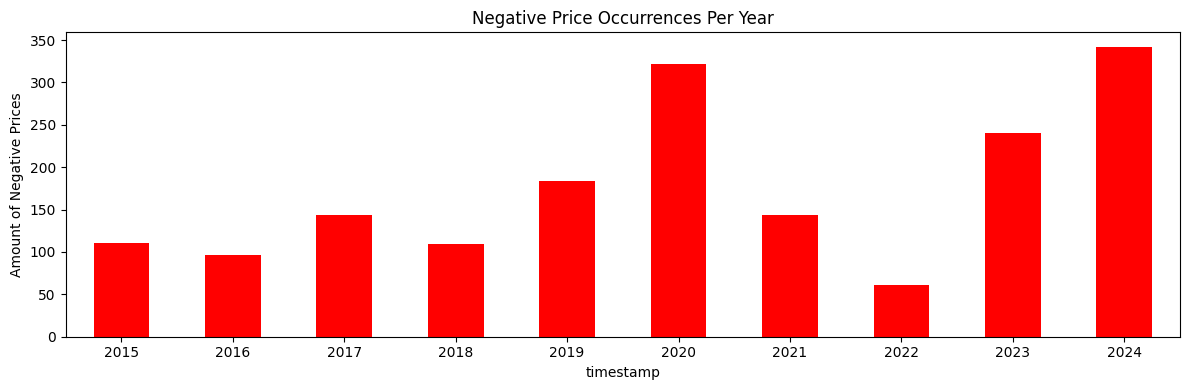

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87661 entries, 2015-01-01 01:00:00 to 2024-12-31 23:00:00
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price_eur_per_mwh                  87661 non-null  float64
 1   forecast_net_load_mwh              86362 non-null  float64
 2   forecast_residual_load_mwh         86338 non-null  float64
 3   forecast_total_mwh                 87589 non-null  float64
 4   forecast_wind_offshore_mwh         87637 non-null  float64
 5   forecast_wind_onshore_mwh          87659 non-null  float64
 6   forecast_solar_mwh                 87659 non-null  float64
 7   forecast_other_mwh                 87565 non-null  float64
 8   hour                               87661 non-null  int32  
 9   weekday                            87661 non-null  int32  
 10  month                              87661 non-null  int32  
 11  year               

In [773]:
# Make sure not to use date we should not know
shifted = df["price_eur_per_mwh"].shift(1)

# Add new feature to DataFrame
df["negative_price_amount"] = np.where(shifted < 0, -shifted, 0)

# Count the negative prices per year (YE)
negative_counts = (df["negative_price_amount"] > 0).resample("YE").sum()

# Plot configuration
plt.figure(figsize=(12,4))
plt.title("Negative Price Occurrences Per Year")
plt.xlabel("Year")
plt.ylabel("Amount of Negative Prices")

# Make tick labels only show the year and not the full timestamp
ax = negative_counts.plot(kind="bar", color="red")
ax.set_xticks(range(len(negative_counts)))
ax.set_xticklabels(negative_counts.index.year.astype(str), rotation=0)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

df.info()

As seen in the plot above, negative prices increased from 2015 to 2020 due to rising renewable energy that caused an oversupply. The peak in 2020 was most likely caused by the Covid Pandemic, which significantly reduced electricity demand. After 2020, the number of negative prices dropped in 2021 and 2022, likely due to a recovery in demand and more flexible grid management. However, in 2023 and 2024, the amount of negative prices rose again, possibly because the growth in renewable energy.

## Development of Energy Generation
In this sub-section, we move away from the electricity prices and take a look at the **monthly forecasts of different electricity generation sources** over time between 2015 and 2025. Note that the values are only forecasts, but they still offer a reliable approximation of the actual generation trends over time. This helps to identify trends and seasonal patterns in specific renewable sources like wind (offshore and onshore) and solar power, which are the two most important renewable sources influencing energy prices. By averaging monthly, we reduce noise and create a clearer, more readable visualization of long-term developments.


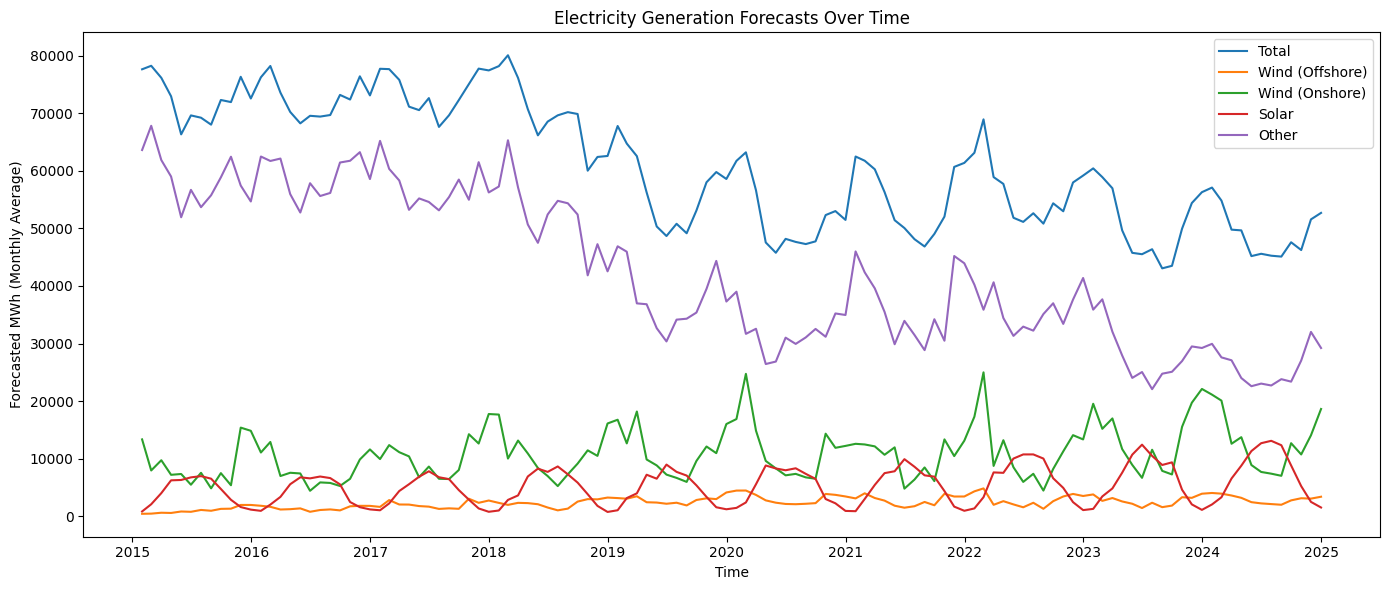

In [774]:
# Features and corresponding labels to plot
features = [
    ("forecast_total_mwh", "Total"),
    ("forecast_wind_offshore_mwh", "Wind (Offshore)"),
    ("forecast_wind_onshore_mwh", "Wind (Onshore)"),
    ("forecast_solar_mwh", "Solar"),
    ("forecast_other_mwh", "Other")
]

plt.figure(figsize=(14, 6))

# Resample monthly (ME) and calculate mean for more readability
df_monthly = df[[feature[0] for feature in features]].resample("ME").mean() # we need to only use the first entry of each tuple!

# Add features to plot with their labels
for feature, label in features:
    plt.plot(df_monthly.index, df_monthly[feature], label=label)

# Plot configuration
plt.title("Electricity Generation Forecasts Over Time")
plt.xlabel("Time")
plt.ylabel("Forecasted MWh (Monthly Average)")
plt.legend()
plt.tight_layout()
plt.show()

<u>A Brief Explanation of the Major Takeaways:</u>
- `Total` contains the forecasted total electricity generation from **all sources combined**. We can see a decreasing trend, primarily due to the decline in `Other` sources.
- `Other` refers to fossil fuels like coal, gas and oil, as well as nuclear power, hydropower and biomass. This category shows a downward trend due to the gradual reduction of fossil fuel in favor of renewables. Note that since April 2023, Germany no longer generates from nuclear power.
- `Solar` power is low in winter because less light reaches the panels due to shorter days, the sun being lower in the sky and more clouds.

- Renewables like `Wind (Offshore)`, `Wind (Onshore)` and `Solar` are growing in revelance but still do not dominate as much as `Other` sources do. They all show clear seasonal patterns as they depend on weather and daylight. `Wind (Onshore)` is the most significant renewable contributor.
- Wind that is generated onshore (on land) fluctuates a lot, whereas offshore wind (over the sea) is very stable, but overall low. Both do not show a strong upward or downward trend in long-term.


## Development of Net Load and Residual Load

The next plot shows forecasts of the net load and residual load from 2015 to 2025. Again, by monthly averaging, we highlight seasonal patterns and remove noise. Net load reflects electricity demand minus renewable generation, while residual load indicates the share that must be covered by conventional sources. See the notes below for a brief explanation.

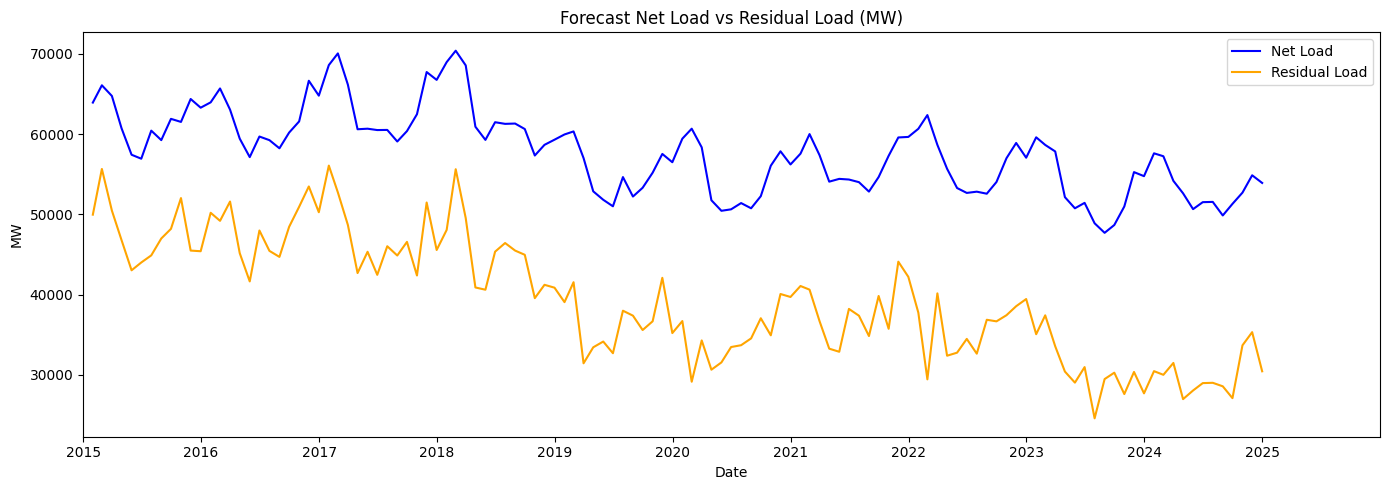

In [775]:
start_date = pd.Timestamp("2015-01-01")
end_date = pd.Timestamp("2025-12-31")

# Only show monthly mean for more readability
df_monthly = df[["forecast_net_load_mwh", "forecast_residual_load_mwh"]].resample("ME").mean()

plt.figure(figsize=(14, 5))
plt.plot(df_monthly.index, df_monthly["forecast_net_load_mwh"], label="Net Load", color="blue")
plt.plot(df_monthly.index, df_monthly["forecast_residual_load_mwh"], label="Residual Load", color="orange")

plt.xlim(start_date, end_date)
plt.title("Forecast Net Load vs Residual Load (MW)")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.tight_layout()
plt.show()

<u>Important Notes:</u>
- The `Net Load` represents the predicted electricity demand minus the expected generation from several renewables such as wind and solar. It stays relatively stable over the years, with minor fluctuations. However, it shows a slight overall downward trend.
- The `Residual Load` shows the amount of electricity demand that must be met by conventional sources including fossil fuels, nuclear and biomass. This value is generally lower than the net load and shows higher volatility.
- Both Features show seasonal patterns, with higher values in winter. This means, that in winter, electricity demand is higher, because of cold temperatures as well as lower solar generation. As a result, the net load and residual load rise.
- The `Residual Load` is much more volatile, due to intermittency of renewable sources like wind and solar. Sudden drops may occur because renewables generate a surplus. Furthermore, we can observe overall downward trend from 2015 until 2025 because of increasing renewable generation.

## Correlation of Features
To conclude this EDA, let's plot the correlation matrix of some important features. The output will be a table that shows how strongly numerical values are **lineraly related** to each other. This is a quick way to identify which features are related to the target variable or to other features. Each value ranges from `-1` to `1`, where `1` represents a perfect positive correlation. This means, that both values increase together. A `-1` represents a perfect negative correlation, so one value increases and the other decreases. A `0` would mean that there is no linear relationship.

Below the plot, there is a quick explanation of the correlation matrix and its values.

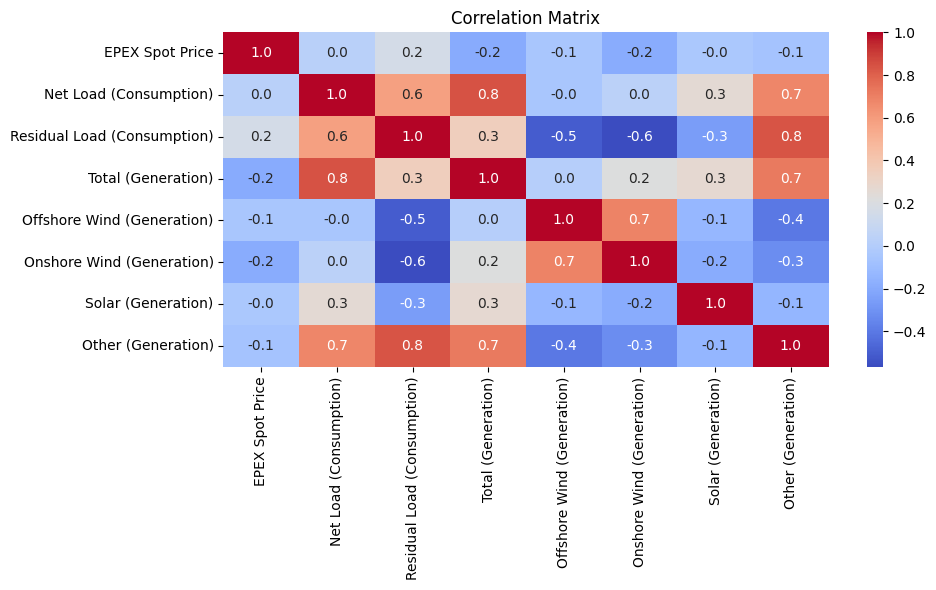

In [776]:
# Sotre Features and labels in a map so we can use the label later for better visualization
features_with_labels = {
    "price_eur_per_mwh": "EPEX Spot Price",
    "forecast_net_load_mwh": "Net Load (Consumption)",
    "forecast_residual_load_mwh": "Residual Load (Consumption)",
    "forecast_total_mwh": "Total (Generation)",
    "forecast_wind_offshore_mwh": "Offshore Wind (Generation)",
    "forecast_wind_onshore_mwh": "Onshore Wind (Generation)",
    "forecast_solar_mwh": "Solar (Generation)",
    "forecast_other_mwh": "Other (Generation)",
}

# Extract the features from the map
features = list(features_with_labels.keys())

# Create correlation matrix with our features
correlation_matrix = df[features].corr()

# Rename the labels of the correlation matrix
correlation_matrix.rename(index=features_with_labels, columns=features_with_labels, inplace=True)

# Plot the matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm") # feed the correlation matrix into the heatmap
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

<u>Key Observations from the Correlation Matrix:</u>
- `EPEX Spot Price` and `Residual Load` have a slight positive correlation (0.2) which makes sense, as prices tend to increase when more electricity is needed from non-renewable sources. This is because, according of the **Merit Order**, more expensive power plants like gas or coal are only used when the demand exceeds renewable supply. 
- `EPEX Spot Price` and `Wind, Solar, Other` show a weak negative correlation (-0.1 to -0.2) because more renewable energy usually lowers the market price due to higher supply.
- `Net Load` and `Total Generation` show a strong correlation (0.8), because when more electricity is consumed, more needs to be generated as well.
- `Residual Load` and renewables like `Wind` and `Solar` show a clear negative correlation, due to less backup energy needed, when wind and solar generation increase.
- `Onshore Wind` and `Offshore Wind` correlate positively because both depend on similar wind patterns.
- `Solar` and `Wind` show no strong relation as their generation follows different seasonal trends. In Germany, there is more wind in winter than in summer. Moreover, there is more sun for solar power in summer than in winter.
- `Other` and `Residual Load` show a stront correlation because energy sources like fossil fuels are mainly used to cover residual demand.

# <font color="RoyalBlue">5 Handling Missing Values</font>
In this short sixth chapter, we briefly discuss the appearance and meaning of **NaN values** in our data sets as well as how we want to handle these missing values. Note that there are **no duplicate values** in our DataFrame, because we are working with a time series and have already taken care of the Daylight Saving Time problem to ensure that we work with unique timestamps.

Firstly, let's see what columns of our DataFrame show NaN values:

In [777]:
# Absolute and percentage amount of NaN values
missing_count = df.isna().sum()
missing_percent = (missing_count / len(df)) * 100

# Construct DataFrame missing_info
missing_info = pd.DataFrame({
    "Missing Values": missing_count,
    "Percentage (%)": missing_percent.round(2)
})

# Only keep columns with NaN values
missing_info = missing_info[missing_info["Missing Values"] > 0]

# Print which columns have NaN values
print(f"Columns with missing values (absolute and in %):\n{missing_info}")

Columns with missing values (absolute and in %):
                            Missing Values  Percentage (%)
forecast_net_load_mwh                 1299            1.48
forecast_residual_load_mwh            1323            1.51
forecast_total_mwh                      72            0.08
forecast_wind_offshore_mwh              24            0.03
forecast_wind_onshore_mwh                2            0.00
forecast_solar_mwh                       2            0.00
forecast_other_mwh                      96            0.11


We can see that we only have missing values in forecasted data. This can occur because the forecasting systems may have failed to produce values for certain timestamps, for example, due to data transmission errors, unavailable input data or system outages during data collection or processing. With around 1300, both `forecast_new_load_mwh` and `forecast_residual_load_mwh` show the highest amount of missing values, whereas the other features contain only few missing entries.

There are multiple ways of dealing with those missing values:

- **Deleting rows with NaN values:** 
This is usually not a good idea for time series forecasting as removing rows breaks the temporal continuity and can lead to loss of information.


- **Filling NaN values:**
This is generally a good idea, especially if the missing values are relatively few. There are multiple ways of imputations like linear interpolation, forward and backward fill, using the mean, median or by model based imputation like with a neural network.

- **Adding an indicator feature that marks rows with NaN values:**
This is also a useful approach as it gives the model information about the presence of previously missing data.

In our case, we combine the last two strategies: for each feature with missing values, we add a binary feature `feature_missing` that indicates whether the value was originally missing. We then apply linear interpolation to fill the actual missing values. This simple approach helps retain all the time series data while still informing the model about previously missing values. 


In [778]:
features_with_nans = missing_info.index.tolist()

# Create new features indicating NaN values and apply linear interpolation for the NaN values after
for feature in features_with_nans:
    df[f"{feature}_missing"] = df[feature].isna().astype(int)
    df[feature] = df[feature].interpolate(method="linear") # linear interpolation alternatives: "time", "nearest"

# Check if we still have NaN values
nan_count = df.isna().sum().sum()
if nan_count > 0:
    print(f"DataFrame contains {nan_count} NaN values")
else:
    print("DataFrame does not contain any NaN values")

DataFrame does not contain any NaN values


# <font color="RoyalBlue">6 Adding Lag Features, Rolling Statistics and Handling Outliers</font>
In this chapter, we define our feature set and the target variable that is to predict. In this regard, we will also create some **lag features** and **rolling statistics** that can be used for the model training in order to gain a better performance of the model. Furthermore, we finally handle outliers by adding a specific feature that indicates whether the current EPEX Spot Price is considered as an outlier or not.

## Adding Lag Features

Lags are values from previous time steps of a time series. For example, lag_1 refers to the value of a variable exactly one time step before the current observation. Lag Features help the model learn temporal dependencies, trends, and recurring patterns that occur over time. As a result, the quality of the predictions will be enhanced.

In [779]:
# Create our target variable
df["price"] = df["price_eur_per_mwh"]

# Add lag features (lag_n is price n hours before)
lags = [1, 2, 4, 5, 6] # these lags seem to work well
for l in lags:
    df[f"lag_{l}"] = df["price"].shift(l)

## Adding Rolling Statistics
Rolling statistics are calculations like the mean, sum or standard deviation, calculated on a moving window of fixed size on sequential data. They help capture local trends and smooth out short-term fluctuations. Overall, this contributes to better model predictions.

In the following, we will add a rolling window for the mean and standard deviation for a chosen set of features. Manual experimentation has shown that the currently used combination of features and window sizes results in the best model performance.

In [780]:
# Define columns to apply rolling statistics to
rolling_columns = [
    "price",
    "forecast_net_load_mwh",
    "forecast_residual_load_mwh",
    "forecast_total_mwh",
    "lag_4",
]

# Rolling windows in hours
windows = [2, 3, 5, 24, 168]

# Compute rolling mean and std (with shift to avoid data leakage)
for col in rolling_columns:
    for w in windows:
        df[f"{col}_roll_mean_{w}"] = df[col].shift(1).rolling(window=w).mean() # okay, because we shift!
        df[f"{col}_roll_std_{w}"] = df[col].shift(1).rolling(window=w).std()


## Handling Outliers
For this project, a data point is considered an outlier if it deviates significantly from its **recent** typical behavior. In this case, we define outliers by using our recently added **Rolling Statistic** features from the sub-section above. To be more precise, an outlier occurs if the current price for a given **window** is:
- greater than `Rolling Mean + (k * Rolling Std)`
- or less than `Rolling Mean - (k * Rolling Std)`

The parameters `k` and `window` are not chosen dynamically but through manual experimentation instead. To keep it simple, we skip dynamic hyperparameter tuning at this point.

Note that outliers can only be detected **after** observing the current value. To **avoid data leakage**, we use the lagged value `lag_1` when creating the outlier feature. This means the model only has access to past information when predicting.

In [781]:
# The combination of k = 3.9 and window = 24 shows the best results for the model 
k = 3.9  # Outlier threshold
window = 24 # this has to be either 3 (3 hours), 24 (1 day) or 168 (7 days)

# Add outlier feature as integer
df["outlier_1h_ago"] = (
    (df["lag_1"] > df[f"price_roll_mean_{window}"] + k * df[f"price_roll_std_{window}"]) |
    (df["lag_1"] < df[f"price_roll_mean_{window}"] - k * df[f"price_roll_std_{window}"])
).astype(int) # use int instead of bool because some models require numeric inputs

## NaN Values again
While computing the lag features and rolling statistics in the previous sub-sections, we have shifted the data and thereby created new missing values, especially due to the maximum rolling window size of 168 hours. These newly introduced NaN values could easily be handled by removing the first 168 rows of the DataFrame. However, we intentionally keep these rows, as the model performs worse when they are removed. 

The following code block shows how they could be removed, if desired:

```python
    df = df.iloc[168:] # remove the first 168 rows
```

Let's briefly look at how many missing values exist and in which columns:

In [782]:
# Get amount of missing values
nans = df.isna().sum()
total_nans = nans.sum()
nans = nans[nans > 0]

# Print amount of missing values
print(f"Total amount of NaN values: {total_nans}")
print(f"Nan values per column:\n{nans}")

Total amount of NaN values: 2078
Nan values per column:
lag_1                                         1
lag_2                                         2
lag_4                                         4
lag_5                                         5
lag_6                                         6
price_roll_mean_2                             2
price_roll_std_2                              2
price_roll_mean_3                             3
price_roll_std_3                              3
price_roll_mean_5                             5
price_roll_std_5                              5
price_roll_mean_24                           24
price_roll_std_24                            24
price_roll_mean_168                         168
price_roll_std_168                          168
forecast_net_load_mwh_roll_mean_2             2
forecast_net_load_mwh_roll_std_2              2
forecast_net_load_mwh_roll_mean_3             3
forecast_net_load_mwh_roll_std_3              3
forecast_net_load_mwh_roll_mean_

We can see, that the maximum amount of NaN values per feature is the same as our maximum window size that we have used to create in the previous sub-sections.

## Defining the Feature Set and Target Label
Finally, we define our feature set and specify the target value to be predicted by the model. In our case, we want to predict the `price`. For doing so, we use every feature that we have added up to this point except for the target label itself of course.

In [783]:
# Define feature set and target variable 
X = df.drop(["price", "price_eur_per_mwh"], axis=1)
y = df["price"]

# Check that we don't have data leakage!
print(X.columns.tolist())

['forecast_net_load_mwh', 'forecast_residual_load_mwh', 'forecast_total_mwh', 'forecast_wind_offshore_mwh', 'forecast_wind_onshore_mwh', 'forecast_solar_mwh', 'forecast_other_mwh', 'hour', 'weekday', 'month', 'year', 'holiday_Christi Himmelfahrt', 'holiday_Erster Mai', 'holiday_Erster Weihnachtstag', 'holiday_Karfreitag', 'holiday_Neujahr', 'holiday_Ostermontag', 'holiday_Pfingstmontag', 'holiday_Reformationstag', 'holiday_Tag der Deutschen Einheit', 'holiday_Zweiter Weihnachtstag', 'pricezone_split', 'negative_price_amount', 'forecast_net_load_mwh_missing', 'forecast_residual_load_mwh_missing', 'forecast_total_mwh_missing', 'forecast_wind_offshore_mwh_missing', 'forecast_wind_onshore_mwh_missing', 'forecast_solar_mwh_missing', 'forecast_other_mwh_missing', 'lag_1', 'lag_2', 'lag_4', 'lag_5', 'lag_6', 'price_roll_mean_2', 'price_roll_std_2', 'price_roll_mean_3', 'price_roll_std_3', 'price_roll_mean_5', 'price_roll_std_5', 'price_roll_mean_24', 'price_roll_std_24', 'price_roll_mean_168'

All our features are **free of data leakage** because they are either available at prediction time or are based on past values using lagging and shifting methods.

# <font color="RoyalBlue">7 Model Training, Prediction and Evaluation</font>
In this section, we will split our data and train our first model on it. The model will predict future EPEX Spot energy prices of the German price zone using the train data. After that, we take a look at different evaluation metrics, including the **RMSE** (Root Mean Squared Error), **MAE** (Mean Absolute Error), and **R² score** (Coefficient of Determination).

## Split the Dataset Chronologically
First of all, we split our data into train and test data. We need to make sure that the data is not split randomly, but instead chronologically, ensuring the model is trained on past data and tested on future data. This avoids **Data Leakage**, a problem where information from the future is unintentionally used in the training process, leading to an overly optimistic model performance. 

By taking a look at the final print statements, we can see that the train data now ranges from 2015-01-01 until 2023-01-01 and the test data ranges from 2023-01-01 until 2024-12-31.

In [784]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

Let's look at the number of rows and date ranges for both training and test splits. We can see that the split is pretty close to 80:20, which matches our intended ratio:

In [785]:
# Used for calculating percentage of lines in each set
total_len = len(X)

# For X_train
print(f"X_train:  Lines: {len(X_train)} ({len(X_train)/total_len*100:.3f}%)  Span: {X_train.index.min()} until {X_train.index.max()}")

# For y_train
print(f"y_train:  Lines: {len(y_train)} ({len(y_train)/total_len*100:.3f}%)  Span: {y_train.index.min()} until {y_train.index.max()}")

# For X_test
print(f"X_test:   Lines: {len(X_test)} ({len(X_test)/total_len*100:.3f}%)  Span: {X_test.index.min()} until {X_test.index.max()}")

# For y_test
print(f"y_test:   Lines: {len(y_test)} ({len(y_test)/total_len*100:.3f}%)  Span: {y_test.index.min()} until {y_test.index.max()}")

df.info()


X_train:  Lines: 70128 (79.999%)  Span: 2015-01-01 01:00:00 until 2023-01-01 08:00:00
y_train:  Lines: 70128 (79.999%)  Span: 2015-01-01 01:00:00 until 2023-01-01 08:00:00
X_test:   Lines: 17533 (20.001%)  Span: 2023-01-01 09:00:00 until 2024-12-31 23:00:00
y_test:   Lines: 17533 (20.001%)  Span: 2023-01-01 09:00:00 until 2024-12-31 23:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87661 entries, 2015-01-01 01:00:00 to 2024-12-31 23:00:00
Data columns (total 88 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   price_eur_per_mwh                         87661 non-null  float64
 1   forecast_net_load_mwh                     87661 non-null  float64
 2   forecast_residual_load_mwh                87661 non-null  float64
 3   forecast_total_mwh                        87661 non-null  float64
 4   forecast_wind_offshore_mwh                87661 non-null  float64
 5   forecast_w

Note that our train data set ranges from January 2015 until January 2023. This time period will be used to train our model in the next sub-chapter. The test data set covers the time from January 2023 until the end of 2024 in December. This time period will be used to test and evaluate our model.

## Create and Train the Model (XGBRegressor)
In this sub-section, we finally create our model and fit the training data on it. After this, we predict on the test data and print several error metrics in order to evaluate the performance. We use a `XGBRegressor` model from the `XGBoost` Library. Note that since XGBoost is a tree-based model, it internally handles features without requiring normalization or scaling.

The three most important parameters for the `XGBRegressor` are:
- `n_estimators`: the number of trees, more trees can improve performance but increase training time and risk of overfitting.
- `learning_rate`: The step size shrinkage that is used to prevent overfitting. Smaller values increase training time but often result in better results.
- `max_depth`: The maximum depth of each individual tree. Higher values allow the model to understand more complex data but can also quickly lead to overfitting

Several methods for hyperparameter optimization, such as `GridSearchCV` and `RandomizedSearchCV` combined with cross-validation strategies like `TimeSeriesSplit`, have shown that the best combination for our model is as shown in the code block below. However, due to their high computational cost, especially with large grids of hyperparameters, we do not apply these methods here, but instead directly use the best-found parameters.

In [786]:
# Create the model with the best found parameters
model = XGBRegressor(
    n_estimators=590,
    learning_rate=0.1,
    max_depth = 6, # default value
)

# Train the model on the training data set
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

## Evaluate the Model (RMSE, MAE, R² Score)
To understand how our model performed, we need to look at some key evaluation metrics that help us quantify the prediction errors and the overall fit of the model:
- The `RMSE` measures, on average, how much the predicted values differ from the actual values. By taking the square root of squared errors, it penalizes larger errors more heavily. The smaller the RMSE, the better the model is at making predictions.
- The `MAE` measures the absolute difference between predicted values and actual values. Unlike RMSE, it doesn't square the errors, so it treats all errors equally, without penalizing large errors more. As a result, the MAE is easier to understand, but less sensitive to outliers.
- The `R²-Score` indicates how much better the model's predictions are compared to just simply predicting the average target value. It ranges from negative infinity to 1, with values closer to 1 meaning a better fit.

In [787]:
# Get our error metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the error metrics
print(f"RMSE: {rmse:.4f} EUR/MWh")
print(f"MAE: {mae:.4f} EUR/MWh")
print(f"R²: {r2:.4f}")

RMSE: 10.9288 EUR/MWh
MAE: 6.0750 EUR/MWh
R²: 0.9492


Our model resulted with a `RMSE` of about 10.9 EUR/MWh indicating that, on average, the predictions deviate from the true values by around 10.9 units. Our `RMSE` is higher than the `MAE` because it penalized larger errors more strongly, which often come from sudden peaks or spikes in the data. 

The `MAE` of approximately 6.0 EUR/MWh confirms that the average absolute error is relatively small, compared to the `RMSE`. This means that the model's predictions are quite close to the actual values most of the time, when no peak occurs. 

The `R² Score` of about 0.95 means that our model's predictions are much closer to the actual values than simply predicting the average would be. In our case, it predicts 95% better than the average. This high value shows, that the features explain most of the variation in the target data, indicating a strong fit on our data.

## Real Values vs. Predicted Values
For further understanding of our model's predictions, we plot the real values against the predictions. As we know from the previous chapter, since the RMSE is quite higher than the MAE, we can assume that the model makes larger errors on certain data points, likely during spikes or dips, where price movements are more extreme and harder to predict. This can be seen in the following plot:

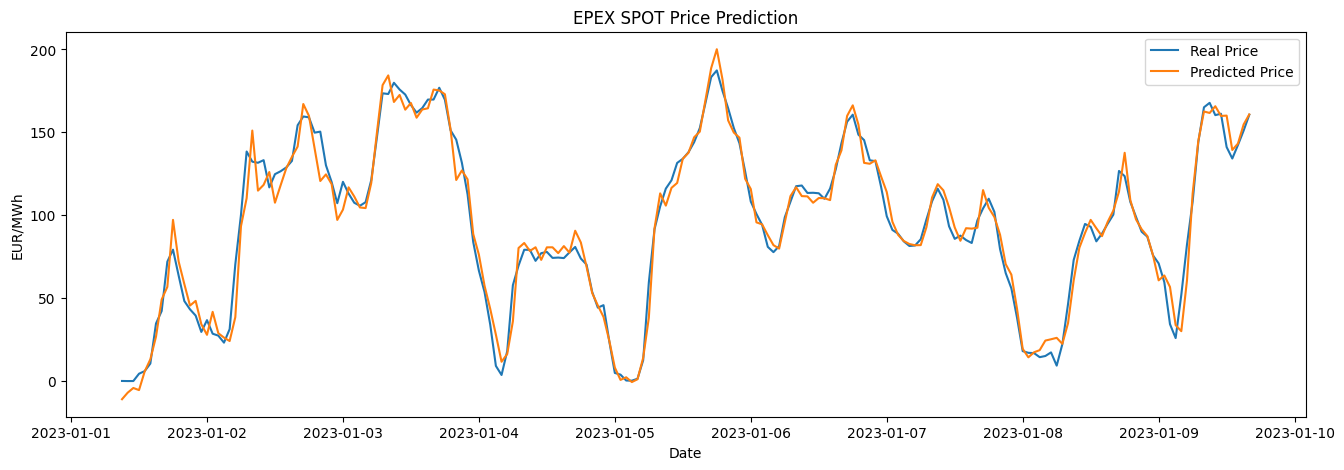

In [788]:
plt.figure(figsize=(16, 5))
plt.plot(y_test.index[:200], y_test.values[:200], label="Real Price")
plt.plot(y_test.index[:200], y_pred[:200], label="Predicted Price")
plt.legend()
plt.title("EPEX SPOT Price Prediction")
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()

## Feature Importance
To finish this chapter, let's now explore how each of our features contributed to the model's prediction by looking at their **Feature Importance** scores. These scores tell us, for each individual feature, how important it is in the model's decision-making process. A higher score means the feature has a greater impact. In `XGBoost`, there are different `importance_type`s to measure this importance. We take a look at the `gain` and `weight` type:
- `gain` measures the average improvement in accuracy, or rather the reduction in loss, resulting from a feature. So this shows, how much a feature contributes to better predictions.
- `weight` counts how many times a feature is used to split the data across all trees. This indicates how frequently the model relies on a specific feature for making decisions.


The feature `lag_1` shows the highest score for both gain and weight, which means it plays a significant role in the prediction. This makes sense because `lag_1` represents the last price value right before the price to predict. Specifically for the `gain`, so for reducing the loss, `lag_1` is by far the most influential feature.

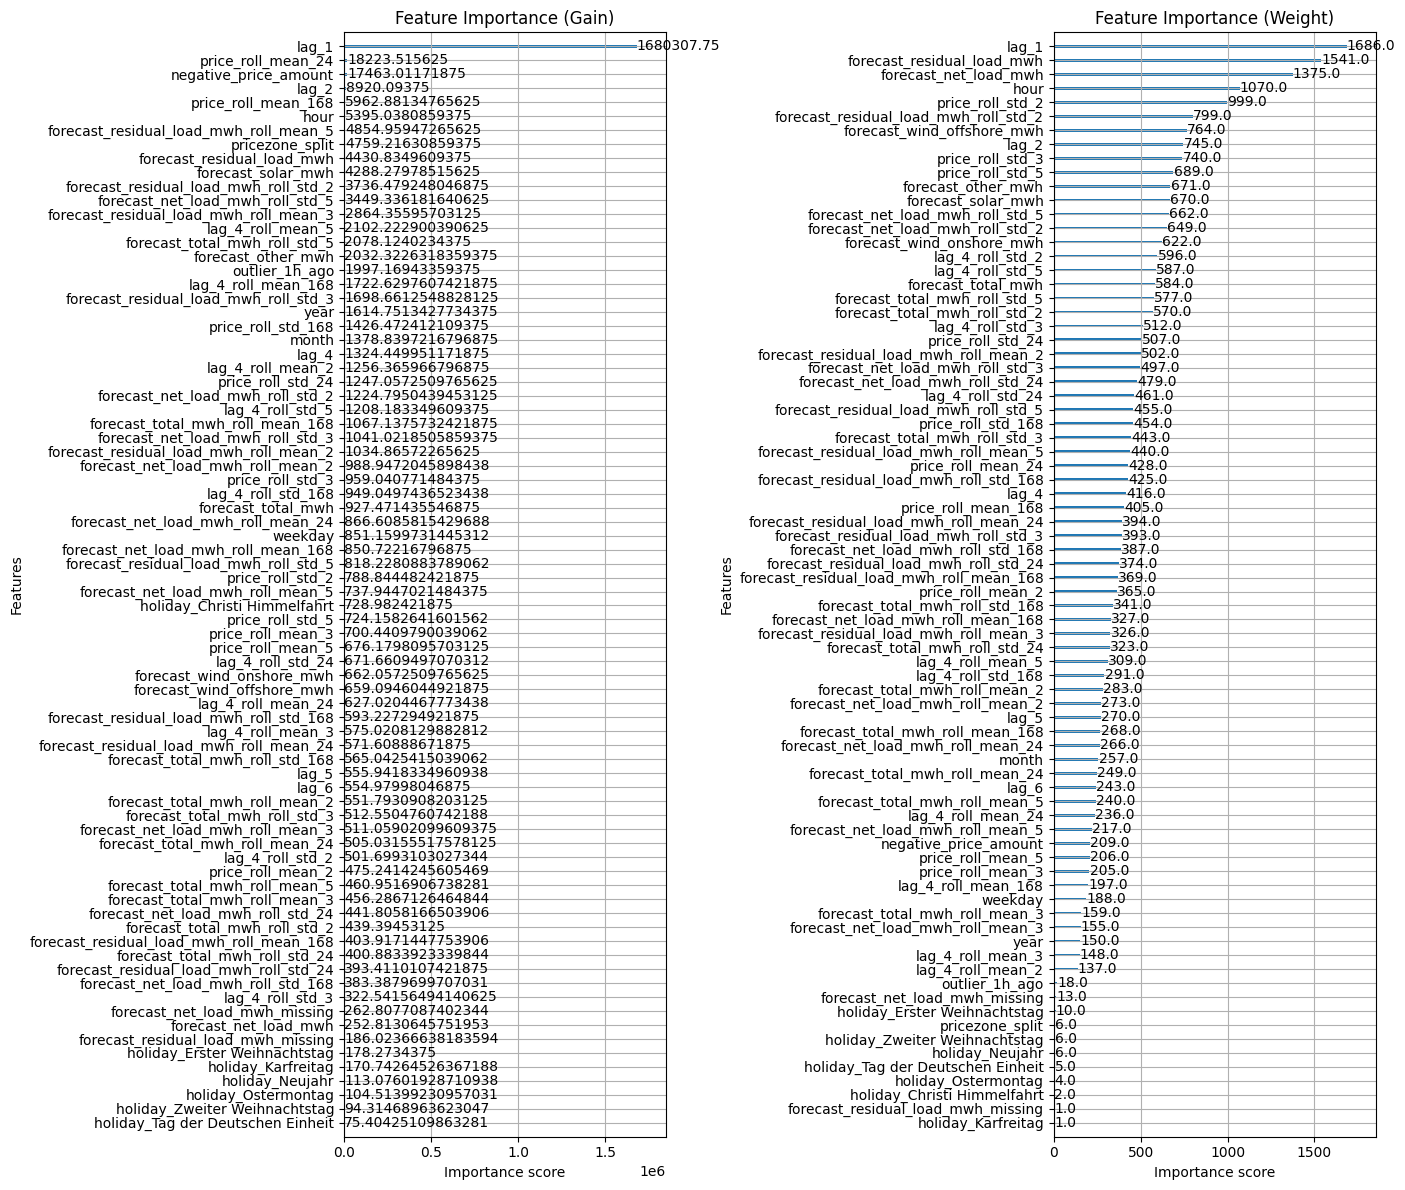

In [789]:
# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 12))

# Left plot (axes[0]) shows gain
plot_importance(model, ax=axes[0], importance_type="gain", title="Feature Importance (Gain)")

# Right plot (axes[1]) shows weight
plot_importance(model, ax=axes[1], importance_type="weight", title="Feature Importance (Weight)")

# Show plot
plt.tight_layout()
plt.show()

# <font color="RoyalBlue">8 Conclusion</font>
In this final chapter, we briefly review what we have done and then discuss several ways to further improve our model.

## Summary of this Project

To sum up this project, let's quickly review what we have done. Firstly, after loading the datasets, we created a clean timestamp column and ensured it was free of duplicates. We then used this timestamp to merge our DataFrames into one single DataFrame. To further enrich our data, we created several time-based features as well as information about public German holidays. Later on, we added lag features and rolling statistics to capture temporal patterns and allow our model to better understand trends. In the EDA, we visualized our data through various plots in order to gain a deeper insight into the German EPEX Spot electricity market. After handling missing values and outliers, we finally trained and evaluated our regression model using metrics such as RMSE, MAE and the R² Score. With an R² Score of about 0.95, our model proved a strong predictive performance on unseen data. However, for a real-world application this project should further be improved as discussed in the following.

## Further Model Improvement
One way to improve the model would be to use data spanning over a longer time period. In this project, we worked with 10 years of data ranging from 2015 until 2025. Including data from further back in time could help the model learn more patterns and improve its performance. Besides data quantity, data quality is equally important. By adding more relevant features such as temperature, electricity import and export or CO2 prices, the prediction accuracy could also be improved. However, acquiring rich and consistent datasets turned out to be very challenging, which is why this project is limited to 10 years of data with only some but very important key features.

Another way to improve our model is to increase the temporal resolution of the data. Instead of hourly forecasts, using quarter-hourly intervals could allow the model to better capture sudden peaks in data. However, this would multiply the dataset size and training time significantly. In practice, a lot of quarter-hourly data is more sparse and inconsistent, so for this project, hourly data was a reasonable compromise.

Further improvements could be achieved through a more advanced hyperparameter tuning and more sophisticated methods for handling and filling missing values, for example by using other models like neural networks. However, these approaches are beyond the scope of this project.

Lastly, the model selection itself plays a crucial role for the prediction accuracy. In this project, we opted for an XGBoost regressor (`XGBRegressor`), which slightly outperformed other tree-based models. These other tree-based models were trained on the exact same data and include a classical Gradient Boosting model (`GradientBoostingRegressor` from scikit-learn) with an RMSE of 12.57, a Light Gradient Boosting Machine (`LGBMRegressor` from LightGBM) with an RMSE of 11.24, a CatBoost model (`CatBoostRegressor` from CatBoost) with an RMSE of 10.89 and a traditional Random Forest regressor (`RandomForestRegressor` from scikit-learn) with an RMSE of 11.71. Other classical statistical time series models such as SARIMA (Seasonal AutoRegressive Integrated Moving Average) or neural networks like LSTM (Long Short-Term Memory) networks could also result in very successful outcomes. However, SARIMA focuses less on feature engineering and more on tuning model parameters. LSTM networks typically require more data and computational resources, making them somewhat overkill for this project. As a result, these approaches were intentionally excluded to maintain the focus on a typical machine learning workflow based on tabular data. 